# Mean Reversion Strategy

**Goal.** Implement and evaluate a simple **mean reversion** (contrarian) strategy based on rolling z-scores.  
We will compare it to Buy & Hold and 12-month momentum, and analyze sensitivity to parameters.


## Step 1 — (Imports & Config)

In [9]:

import sqlite3
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

# --- Database ---
DB_PATH = Path(r"C:\Users\Ruben\Desktop\Projects\InvestmentStrategies\market.db")
TABLE     = "prices"               # expects columns: date, symbol, close

# --- Universe (feel free to adjust) ---
TICKERS   = ["VTI","SPY","QQQ","AAPL","MSFT","AGG","IEF","GLD","DBC","VNQ"]

# --- Backtest window ---
START     = "2015-01-01"
END       = "2025-01-01"

# --- Conventions & costs ---
TRADING_DAYS = 252
COST_BP      = 10     # per unit turnover at the asset layer (0 to disable)
REBAL        = "D"    # we implement mean reversion daily by default


## Step 2 — Load Prices

**Short.** Query a wide panel of adjusted close prices (rows = dates, columns = symbols).  
We use parameterized SQL and pivot to a wide matrix for vectorized operations.


In [10]:

placeholders = ",".join([f":s{i}" for i,_ in enumerate(TICKERS)])
q = f"""
SELECT date, symbol, close
FROM {TABLE}
WHERE symbol IN ({placeholders})
  AND date BETWEEN :start AND :end
ORDER BY date ASC
"""
params = {**{f"s{i}": t for i, t in enumerate(TICKERS)},
          "start": START, "end": END}

with sqlite3.connect(DB_PATH) as con:
    df = pd.read_sql_query(q, con, params=params, parse_dates=["date"])

prices = (df.pivot(index="date", columns="symbol", values="close")
            .sort_index()
            .ffill()
            .dropna(how="any"))

print("Prices:", prices.shape, prices.index.min().date(), "→", prices.index.max().date())
prices.head()


Prices: (2516, 10) 2015-01-02 → 2024-12-31


symbol,AAPL,AGG,DBC,GLD,IEF,MSFT,QQQ,SPY,VNQ,VTI
date,,,,,,,,,,
2015-01-02,24.261045,82.784714,15.931045,114.080002,84.720901,39.933052,94.906555,171.093674,53.596233,88.342422
2015-01-05,23.577570,82.964638,15.703834,115.800003,85.237823,39.565842,93.514397,168.003815,53.889542,86.824432
2015-01-06,23.579784,83.174538,15.555271,117.120003,85.810440,38.985115,92.260544,166.421371,54.424095,85.973717
2015-01-07,23.910439,83.159523,15.459144,116.430000,85.794518,39.480427,93.449860,168.495178,55.258480,86.999603
2015-01-08,24.829126,83.032120,15.520315,115.940002,85.444656,40.641872,95.238464,171.485123,55.467068,88.534248


## Step 3 — Utilities (Weights, Costs, Metrics)

**Short.** Helper functions to normalize weights, compute portfolio returns with costs, and produce standard performance metrics.


In [11]:

def normalize_rows(df: pd.DataFrame) -> pd.DataFrame:
    s = df.sum(axis=1).replace(0, np.nan)
    return df.div(s, axis=0).fillna(0.0)

def apply_rebalancing(weights: pd.DataFrame, freq: str = "D") -> pd.DataFrame:
    f = freq.upper()
    if f in ("M","ME"):
        monthly = weights.resample("ME").last()
        return monthly.reindex(weights.index).ffill().fillna(0.0)
    elif f == "D":
        return weights
    else:
        raise ValueError("freq must be 'D' or 'M/ME'")

def portfolio_returns(returns: pd.DataFrame,
                      weights: pd.DataFrame,
                      cost_bp: int = 0) -> pd.Series:
    returns = returns.reindex(weights.index).fillna(0.0)
    port = (returns * weights).sum(axis=1)
    if cost_bp and cost_bp > 0:
        dw = (weights - weights.shift(1)).abs().sum(axis=1) * 0.5
        port = port - dw * (cost_bp * 1e-4)
    return port

def cagr_from_nav(nav: pd.Series, trading_days: int = TRADING_DAYS) -> float:
    nav = nav.dropna()
    if nav.empty: return 0.0
    years = len(nav) / trading_days
    return float((nav.iloc[-1] / nav.iloc[0])**(1/years) - 1)

def sharpe(returns: pd.Series, trading_days: int = TRADING_DAYS) -> float:
    r = returns.dropna()
    if r.empty: return 0.0
    mu = r.mean() * trading_days
    sd = r.std(ddof=0) * np.sqrt(trading_days)
    return float(mu / sd) if sd > 0 else 0.0

def max_drawdown(nav: pd.Series) -> float:
    roll_max = nav.cummax()
    dd = nav / roll_max - 1.0
    return float(dd.min())

def report_from_returns(r: pd.Series, name: str) -> pd.DataFrame:
    nav = (1 + r).cumprod()
    out = pd.DataFrame({
        "Strategy": [name],
        "CAGR": [cagr_from_nav(nav)],
        "Volatility": [r.std(ddof=0) * np.sqrt(TRADING_DAYS)],
        "Sharpe(≈)": [sharpe(r)],
        "MaxDrawdown": [max_drawdown(nav)],
    }).set_index("Strategy")
    return out.round(6)


## Step 4 — Mean Reversion Logic

**Short.** Use **z-scores** of prices to identify temporary deviations from a rolling mean.

**Z-score.** For window $W$,
$$
z_{t} = \frac{P_t - \mu_{t}(W)}{\sigma_{t}(W)}, \quad
\mu_t(W) = \text{MA}_W(P), \quad \sigma_t(W) = \text{STD}_W(P).
$$

**Signal (long-only contrarian).**  
- Enter long if $z_t < -z_{\text{entry}}$ (oversold).  
- Exit (flat) if $z_t > -z_{\text{exit}}$ (reversion towards mean).  
We apply a **one-day execution lag** to avoid look-ahead.


In [12]:

def mean_rev_zscore_rw(prices: pd.DataFrame,
                       window: int = 20,
                       z_entry: float = 1.0,
                       z_exit: float = 0.5,
                       rebal: str = "D") -> tuple[pd.Series, pd.DataFrame]:
    """
    Long-only contrarian: buy when z < -z_entry, flat when z > -z_exit.
    Weights are normalized across assets with signals, then shifted by 1 day.
    """
    rets = prices.pct_change()
    ma = prices.rolling(window, min_periods=window).mean()
    sd = prices.rolling(window, min_periods=window).std(ddof=0)
    z  = (prices - ma) / sd.replace(0, np.nan)

    long_sig = (z < -z_entry).astype(float)
    flat_sig = (z > -z_exit).astype(float)

    # Convert to positions: 1 when long, 0 when flat; hysteresis via exit rule
    pos = pd.DataFrame(0.0, index=prices.index, columns=prices.columns)
    # Start from previous pos; update by rules
    prev = pd.Series(0.0, index=prices.columns)
    for t in prices.index:
        p = prev.copy()
        # enter where long_sig is 1
        p[long_sig.loc[t] == 1.0] = 1.0
        # exit where flat_sig is 1
        p[flat_sig.loc[t] == 1.0] = 0.0
        pos.loc[t] = p
        prev = p

    # Equal-weight among active longs
    w = normalize_rows(pos)
    w = apply_rebalancing(w, rebal)
    w = w.shift(1).fillna(0.0)  # execute next day

    r = (rets * w).sum(axis=1)  # raw portfolio returns (no costs)
    return r, w


## Step 5 — Baselines for Comparison

**Short.** Build Buy & Hold (equal-weight) and 12–1 momentum baselines to benchmark mean reversion.


In [13]:

def bh_equal_rw(prices: pd.DataFrame, rebal: str = "D") -> tuple[pd.Series, pd.DataFrame]:
    rets = prices.pct_change()
    w = pd.DataFrame(1.0, index=prices.index, columns=prices.columns)
    w = normalize_rows(w)
    w = apply_rebalancing(w, rebal)
    w = w.shift(1).fillna(0.0)
    r = (rets * w).sum(axis=1)
    return r, w

def momentum_12m_rw(prices: pd.DataFrame,
                    lookback: int = 252,
                    skip_last_month: bool = True,
                    top_k: int | None = None,
                    rebal: str = "ME") -> tuple[pd.Series, pd.DataFrame]:
    rets = prices.pct_change()
    shift_curr = 21 if skip_last_month else 0
    mom = prices.shift(shift_curr) / prices.shift(lookback) - 1.0
    mom_m = mom.resample("ME").last()
    if top_k is not None and top_k > 0:
        ranks = mom_m.rank(axis=1, method="first", ascending=False)
        sel = (ranks <= top_k).astype(float)
    else:
        sel = (mom_m > 0).astype(float)
    w_m = normalize_rows(sel)
    w = w_m.reindex(prices.index).ffill().fillna(0.0)
    w = apply_rebalancing(w, rebal)
    w = w.shift(1).fillna(0.0)
    r = (rets * w).sum(axis=1)
    return r, w


## Step 6 — Run Strategies

**Short.** Compute daily returns for **Mean Reversion**, **Buy & Hold**, and **12M-1 momentum** on the same universe.


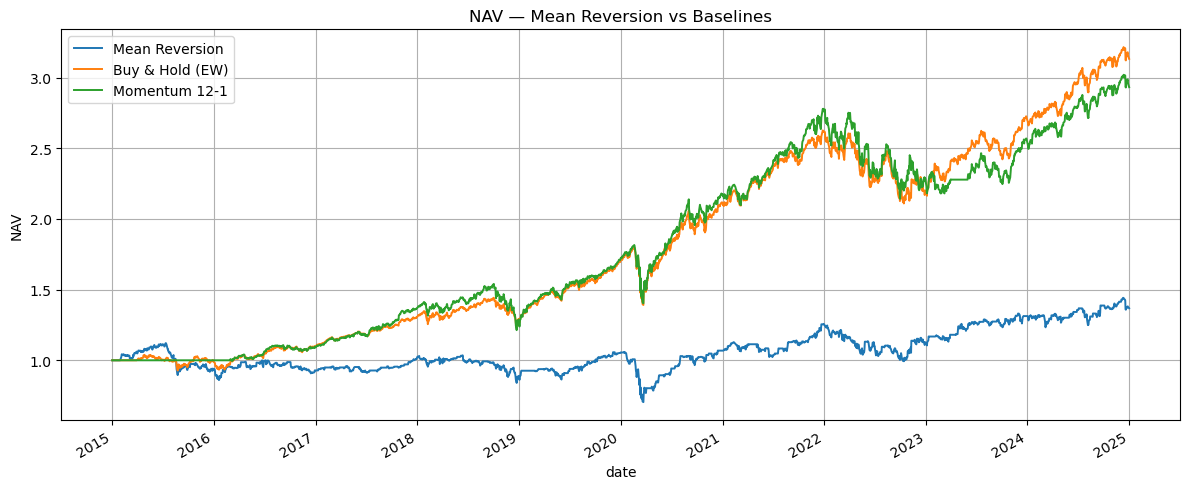

In [14]:

rets_assets = prices.pct_change()

# Mean Reversion (default params)
MR_W   = 20
MR_IN  = 1.0
MR_OUT = 0.5

mr_r, mr_w   = mean_rev_zscore_rw(prices, window=MR_W, z_entry=MR_IN, z_exit=MR_OUT, rebal="D")
bh_r, bh_w   = bh_equal_rw(prices, rebal="ME")
mom_r, mom_w = momentum_12m_rw(prices, lookback=252, skip_last_month=True, top_k=None, rebal="ME")

# Apply transaction costs to the derived weights (for apples-to-apples)
mr_net  = portfolio_returns(rets_assets, mr_w,  cost_bp=COST_BP)
bh_net  = portfolio_returns(rets_assets, bh_w,  cost_bp=COST_BP)
mom_net = portfolio_returns(rets_assets, mom_w, cost_bp=COST_BP)

# NAV panel
nav = pd.DataFrame({
    "Mean Reversion": (1 + mr_net).cumprod(),
    "Buy & Hold (EW)": (1 + bh_net).cumprod(),
    "Momentum 12-1": (1 + mom_net).cumprod(),
}).dropna()

ax = nav.plot(lw=1.4, title="NAV — Mean Reversion vs Baselines")
ax.set_ylabel("NAV"); plt.tight_layout(); plt.show()


## Step 7 — Performance Summary

**Short.** Compute standard metrics for fair comparison (CAGR, Volatility, Sharpe, Max Drawdown).


In [15]:

rows = []
rows.append(report_from_returns(mr_net,  "Mean Reversion"))
rows.append(report_from_returns(bh_net,  "Buy & Hold (EW)"))
rows.append(report_from_returns(mom_net, "Momentum 12-1"))

summary = pd.concat(rows, axis=0)
summary_fmt = (
    summary.assign(**{
        "CAGR(%)":        summary["CAGR"]*100,
        "Volatility(%)":  summary["Volatility"]*100,
        "MaxDrawdown(%)": summary["MaxDrawdown"]*100
    })
    .drop(columns=["CAGR","Volatility","MaxDrawdown"])
    .sort_values(["Sharpe(≈)","CAGR(%)"], ascending=[False, False])
    .round(3)
)
display(summary_fmt)


,Sharpe(≈),CAGR(%),Volatility(%),MaxDrawdown(%)
Strategy,,,,
Buy & Hold (EW),0.965,12.116,12.696,-22.715
Momentum 12-1,0.848,11.375,13.832,-22.913
Mean Reversion,0.277,3.191,15.917,-37.206


### Step 9 — Discussion & Takeaways

**Performance summary.**  
The mean reversion strategy underperformed both Buy & Hold and 12M Momentum across all key metrics:
- Sharpe ratio ≈ 0.27 vs 0.96 (Buy & Hold);
- CAGR ≈ 3.2% vs 12%;
- Max Drawdown ≈ −37%.

**Interpretation.**  
This result is expected in a predominantly **trending market environment** (2015–2025), where price deviations from moving averages tend to persist rather than revert.  
The z-score logic generates frequent premature entries and exits, leading to high turnover and transaction costs.

**Main limitations:**
- The model assumes mean-reverting behavior in individual assets, which is rare for broad ETFs and large-cap stocks.  
- Daily execution increases costs and noise.
- The strategy is long-only — it does not short overbought assets.

**Where it could work better:**
- In **pair trading** (relative mean reversion between correlated assets);
- In **range-bound instruments** (e.g., bonds, commodities in sideways phases);
- When combined with **momentum** or **volatility targeting** to balance regimes.

**Conclusion.**  
Mean reversion is not inherently ineffective, but it is **regime-dependent**.  
Its standalone performance is weak in sustained bull markets but can provide diversification value when integrated with trend-following strategies.

